Notebook to conceptualize a way to find cells in immunos/dye tracings, and analyze location/density/etc. 

In [ ]:
import tifffile
import numpy as np
import matplotlib.pyplot as plt
from cellpose import models, io, core
from cellpose.io import imread

use_GPU = core.use_gpu()
print('>>> GPU activated? %d'%use_GPU)
io.logger_setup()
model = models.Cellpose(gpu=use_GPU, model_type='cyto3')
#img3d = tifffile.imread(r"D:\Box Sync\confocal\retina\immunos\66\optimization\fixation test isl2_calret_brn3c\Composite.tif")
img3d = tifffile.imread(r"D:\confocal\shark_retina\wholemount\Shark_retina_fused.tif")
img3d = img3d[5:20, 0:2,900:4800,3200:6700]


>>> GPU activated? 1
2025-04-09 16:57:10,575 [INFO] WRITING LOG OUTPUT TO C:\Users\Michael Forsthofer\.cellpose\run.log
2025-04-09 16:57:10,575 [INFO] 
cellpose version: 	3.1.1.1 
platform:       	win32 
python version: 	3.11.5 
torch version:  	2.6.0+cu118
2025-04-09 16:57:10,576 [INFO] ** TORCH CUDA version installed and working. **
2025-04-09 16:57:10,577 [INFO] >>>> using GPU (CUDA)
2025-04-09 16:57:10,578 [INFO] >> cyto3 << model set to be used
2025-04-09 16:57:10,633 [INFO] >>>> loading model C:\Users\Michael Forsthofer\.cellpose\models\cyto3
2025-04-09 16:57:10,707 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)


In [2]:
channels = [0, 1]
diameter = 14
min_size = 1500
#create 3d flow, then make masks in that
#masks, flows, styles, _ = model.eval(img3d, channels=channels, diameter=diameter, do_3D=True, min_size=min_size, cellprob_threshold=0.8)
#create 2d masks, then combine them into 3d
masks, flows, styles, _ = model.eval(img3d, channels=channels, diameter=diameter, do_3D=False, min_size=min_size, stitch_threshold=0.5, anisotropy=5)

2025-04-09 16:57:18,123 [INFO] channels set to [0, 1]
2025-04-09 16:57:18,124 [INFO] ~~~ FINDING MASKS ~~~
2025-04-09 16:57:18,132 [INFO] multi-stack tiff read in as having 15 planes 2 channels
2025-04-09 16:59:55,584 [INFO] 100%|##########| 15/15 [02:35<00:00, 10.38s/it]
2025-04-09 16:59:59,317 [INFO] network run in 159.42s
2025-04-09 17:00:43,708 [INFO] 100%|##########| 15/15 [00:44<00:00,  2.96s/it]
2025-04-09 17:00:43,709 [INFO] stitching 15 planes using stitch_threshold=0.500 to make 3D masks


100%|██████████| 14/14 [00:19<00:00,  1.36s/it]


2025-04-09 17:01:03,374 [INFO] masks created in 64.06s
2025-04-09 17:01:10,807 [INFO] >>>> TOTAL TIME 232.68 sec


Text(0.5, 1.0, 'iplane = 10')

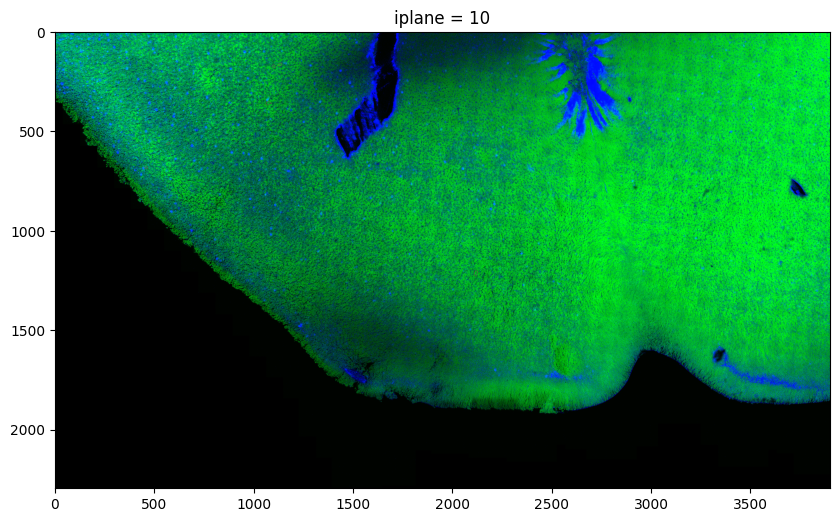

In [4]:
from cellpose import plot, utils
plt.figure(figsize=(10, 10))
iplane = 10
img0 = plot.image_to_rgb(img3d[iplane, [1,0]].copy(), channels=[3,2])

outlines = utils.masks_to_outlines(masks[iplane])
outX, outY = np.nonzero(outlines)
imgout= img0.copy()
imgout[outX, outY] = np.array([255,75,75])
plt.imshow(imgout)
plt.title('iplane = %d'%iplane)

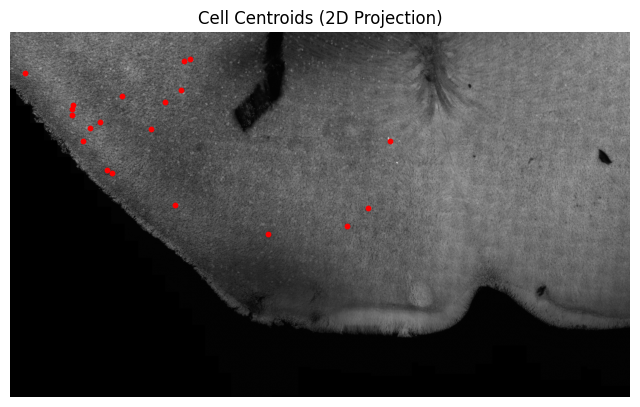

In [5]:
from scipy.ndimage import center_of_mass
import matplotlib.pyplot as plt

# Collapse the 3D mask into 2D by taking the max projection
masks_2d = masks.max(axis=0)  # shape: (Y, X)
# Get all unique object labels (skip 0, which is background)
labels = np.unique(masks_2d)
labels = labels[labels != 0]

# Compute centroids in 2D (Y, X)
centroids = center_of_mass(masks_2d, labels=masks_2d, index=labels)

# Convert to numpy array and split into X and Y
centroids = np.array(centroids)
y_coords, x_coords = centroids[:, 0], centroids[:, 1]

# Optional: show centroids on a max-projected image
img2d = img3d.max(axis=1).mean(axis=0)  # collapse Z and channel

plt.figure(figsize=(8, 8))
plt.imshow(img2d, cmap='gray')
plt.scatter(x_coords, y_coords, s=10, c='r')
plt.title('Cell Centroids (2D Projection)')
plt.axis('off')
plt.show()

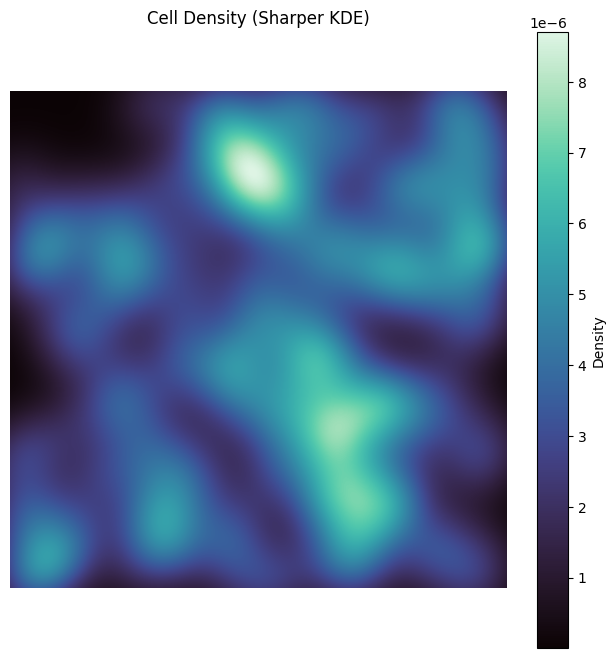

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Set up a grid the same size as your image
img_shape = img3d.shape[2:]  # (Y, X)
grid_x, grid_y = np.meshgrid(np.linspace(0, img_shape[1], img_shape[1]),
                             np.linspace(0, img_shape[0], img_shape[0]))

# Stack x and y coordinates
positions = np.vstack([grid_x.ravel(), grid_y.ravel()])
values = np.vstack([x_coords, y_coords])

# KDE with low bandwidth (sharper)
kde = gaussian_kde(values, bw_method=0.2)  # lower = sharper

# Evaluate KDE on grid
density = kde(positions).reshape(img_shape)

# Plot it
plt.figure(figsize=(8, 8))
plt.imshow(density, cmap='mako', origin='upper')
plt.colorbar(label='Density')
plt.title('Cell Density (Sharper KDE)')
plt.axis('equal')
plt.axis('off')
plt.show()

